# Capstone Project for Coursera
This notebook will be mainly used for capstone project of Coursera online certificate for **IBM Data Science Professional Ceritificate**.

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This project is focus on starting a new restaurant business in Toronto area. By using **k-means clustering method** we can use venues information from Foursquare and filtering the most popular venues in each borough. According to the detail information we can choose the location for new restaurant business.

## Data <a name="data"></a>

The dataset for this capstone project consists of neighborhood information of Toronto obtained from Wikipedia website: [List of postal codes of Canada: M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). By using the BeautifulSoup package of Python, transforming the website data to pandas data frame which include postcode, borough, and neighborhood features. Then according to the transformed data frame obtained latitude and longitude by applying geopy package. Then using the latitude and longitude we can collect venues near each neighborhood for cluster analysis by using Foursquare API.

In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Import Libraries

First import the libraries which will be used in this capstone project.

In [6]:
import json

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm

from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Libraries imported.')

Libraries imported.


### Import Data

Next, using **BeautifulSoup** to transform the data in the table on the Wikipedia page into pandas dataframe. At the same time, cleanning dataframe as the requirement stated.

In [7]:
from bs4 import BeautifulSoup

with open('List of postal codes of Canada_ M - Wikipedia.html') as html_file:
    soup = BeautifulSoup(html_file, 'lxml')


In [8]:
table = soup.find('table', class_='wikitable sortable')
table_rows = table.find_all("tr")
table_columns = table.find_all("th")
l = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    if row and row[1] != 'Not assigned':
        if row[2] == 'Not assigned\n':
            row[2] = row[1]
        l.append(row)
cols = [c.text.replace('\n', '') for c in table_columns]
df = pd.DataFrame(l, columns=cols).replace('\n', '', regex=True)
df = df.groupby(['Borough', 'Postcode'], sort=False).agg(lambda x: ', '.join(set(x.dropna()))).reset_index()
df = df[cols].replace('\n', '', regex=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [9]:
df.shape

(103, 3)

As the result of **shape** method, the size of this transformed table is **(103, 3)**.

Next step is add the **Latitude** and **Longitude** to the dataframe.

In [10]:
ll = pd.read_csv('Geospatial_Coordinates.csv')
ll.columns = ['Postcode', 'Latitude', 'Longitude']
cols = ['Postcode']
df_withll = df.join(ll.set_index(cols), on=cols)

### Use geopy library to get the latitude and longitude values of Toronto

In [11]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Ontario with neighborhoods superimposed on top

Create map of Toronto using latitude and longitude values, and then add markers to map

In [12]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_withll['Latitude'], df_withll['Longitude'], df_withll['Borough'], df_withll['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Then filtering the **Borough** by contains **Toronto**

In [13]:
df_tor = df_withll[df_withll['Borough'].str.contains("Toronto")]
df_tor.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Creating map of Toronto using only Borough that contains Toronto.

In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## Methodology <a name="methodology"></a>

### Define Foursquare Credentials and Version

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [15]:
CLIENT_ID = 'M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W' # your Foursquare ID
CLIENT_SECRET = 'HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W
CLIENT_SECRET:HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB


In [16]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W&client_secret=HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

In [17]:
results = requests.get(url).json()

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Textile Museum of Canada,Art Museum,43.654396,-79.386500
3,Poke Guys,Poke Place,43.654895,-79.385052
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

72 venues were returned by Foursquare.


Then explore neighborhoods in Toronto

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=df_tor['Neighbourhood'],
                                   latitudes=df_tor['Latitude'],
                                   longitudes=df_tor['Longitude']
                                  )



Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, Richmond, King
Dovercourt Village, Dufferin
Union Station, Toronto Islands, Harbourfront East
Trinity, Little Portugal
Riverdale, The Danforth West
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill West, Forest Hill North
The Junction South, High Park
North Toronto West
North Midtown, The Annex, Yorkville
Roncesvalles, Parkdale
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Summerhill East, Moore Park
Kensington Market, Grange Park, Chinatown
Summerhill West, South Hill, Forest Hill SE, Deer Park, Rathnelly
CN Tower, Bathurst Quay, King and Spadina, Island airport, Railway Lands, Harbourfront West, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Und

#### See the size of toronto_venues dataframe

In [23]:
print(toronto_venues.shape)
toronto_venues.head()

(1699, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [24]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, Richmond, King",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower, Bathurst Quay, King and Spadina, Island airport, Railway Lands, Harbourfront West, South Niagara",14,14,14,14,14,14


In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


There are 235 uniques categories can be curated from all the returned venues. Then we analyze each neigborhood.

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [28]:
column_index(toronto_onehot,['Neighborhood'])

array([162])

In [29]:
toronto_onehot = toronto_onehot.set_index(toronto_onehot.columns[159]).reset_index()

In [30]:
toronto_onehot.head()

,Museum,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
toronto_onehot.shape

(1699, 239)

#### Next, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category 

In [32]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Museum,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,"Adelaide, Richmond, King",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03,0.0,0.0,0.010000,0.01,0.0,0.03,0.000000,0.000000,0.0,0.000000,0.020000,0.0,0.040000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.01,0.0,0.01,0.030000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.000000,0.050000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.000000,0.080000,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,

In [33]:
toronto_grouped.shape

(38, 239)

#### Print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, Richmond, King----
             venue  freq
0      Coffee Shop  0.08
1             Café  0.05
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2      Farmers Market  0.04
3              Bakery  0.04
4  Seafood Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.10
1     Coffee Shop  0.10
2  Breakfast Spot  0.10
3   Burrito Place  0.05
4    Climbing Gym  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1         Pizza Place  0.05
2    Recording Studio  0.05
3             Brewery  0.05
4          Skate Park  0.05


----CN Tower, Bathurst Quay, King and Spadina, Island airport, Railway Lands, Harbourfront West, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Ai

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, Richmond, King",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Asian Restaurant,Breakfast Spot,Gym,Hotel,American Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar,Seafood Restaurant,Café,Cheese Shop,Steakhouse,Park
2,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Breakfast Spot,Café,Stadium,Restaurant,Italian Restaurant,Caribbean Restaurant,Intersection,Climbing Gym,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Pizza Place,Garden,Comic Shop,Gym / Fitness Center,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, King and Spadina, Isl...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Sculpture Garden,Boat or Ferry


#### Using both Tsne and PCA to reduce data dimension for better kmeans clustering

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA


toronto_grouped_clustering = np.array(toronto_grouped.drop('Neighborhood', 1))
X_embedded = TSNE(n_components=25, method="exact").fit_transform(toronto_grouped_clustering)
# X_embedded = PCA(n_components=3).fit_transform(toronto_grouped_clustering)
X_embedded.shape

(38, 25)

#### Selecting the number of clusters with silhouette analysis on KMeans clustering
- As the silhouette score shows, the prefered k is 5.

For n_clusters = 4 The average silhouette_score is : 0.06493265
For n_clusters = 5 The average silhouette_score is : 0.21518894
For n_clusters = 6 The average silhouette_score is : 0.03642605
For n_clusters = 7 The average silhouette_score is : 0.05990695
For n_clusters = 8 The average silhouette_score is : 0.05565462
For n_clusters = 9 The average silhouette_score is : 0.04231609
For n_clusters = 10 The average silhouette_score is : 0.023910187
For n_clusters = 11 The average silhouette_score is : 0.12351507
For n_clusters = 12 The average silhouette_score is : 0.03649725
For n_clusters = 13 The average silhouette_score is : 0.035400935
For n_clusters = 14 The average silhouette_score is : 0.031100342
For n_clusters = 15 The average silhouette_score is : 0.03644149
For n_clusters = 16 The average silhouette_score is : 0.025293365
For n_clusters = 17 The average silhouette_score is : 0.050484054
For n_clusters = 18 The average silhouette_score is : 0.019250572
For n_clusters = 19 The a

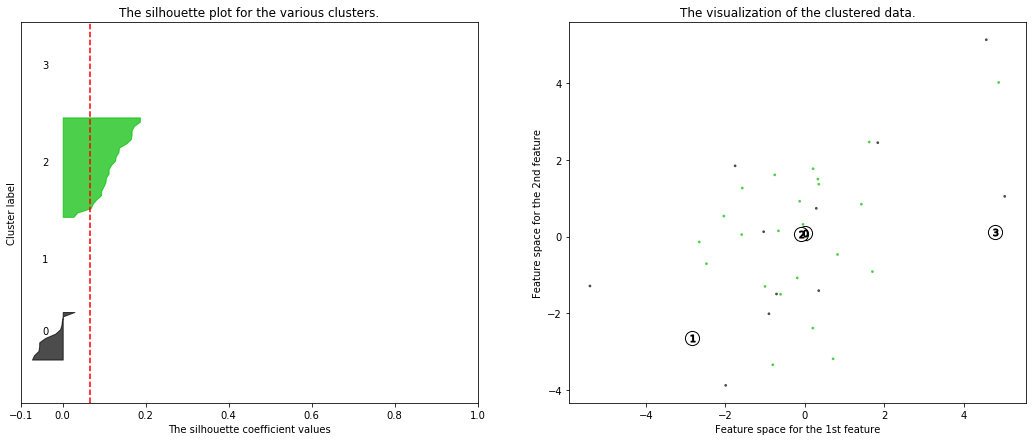

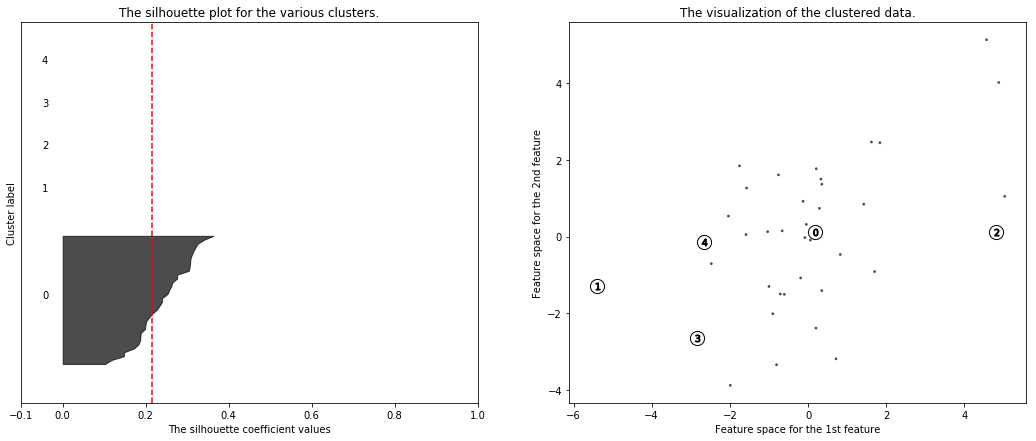

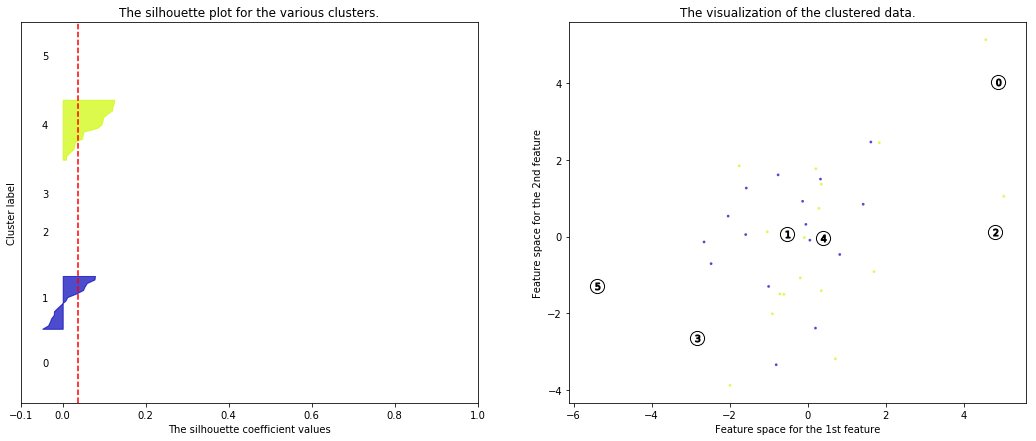

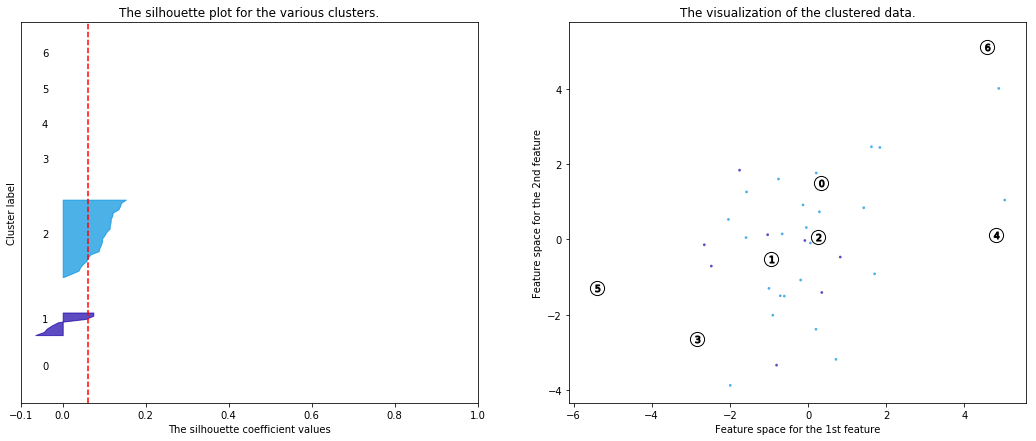

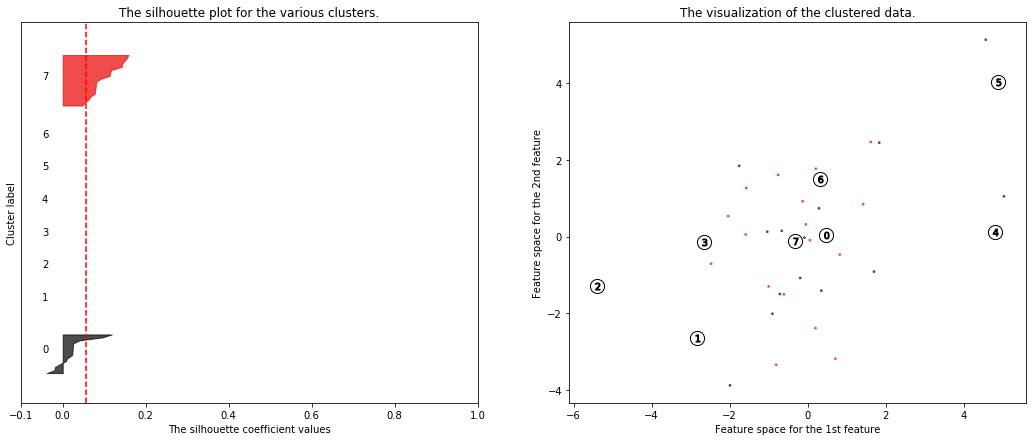

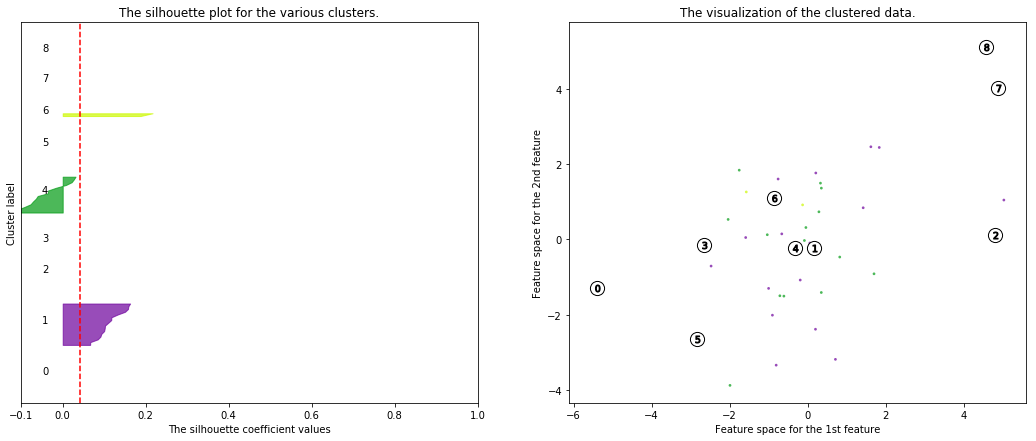

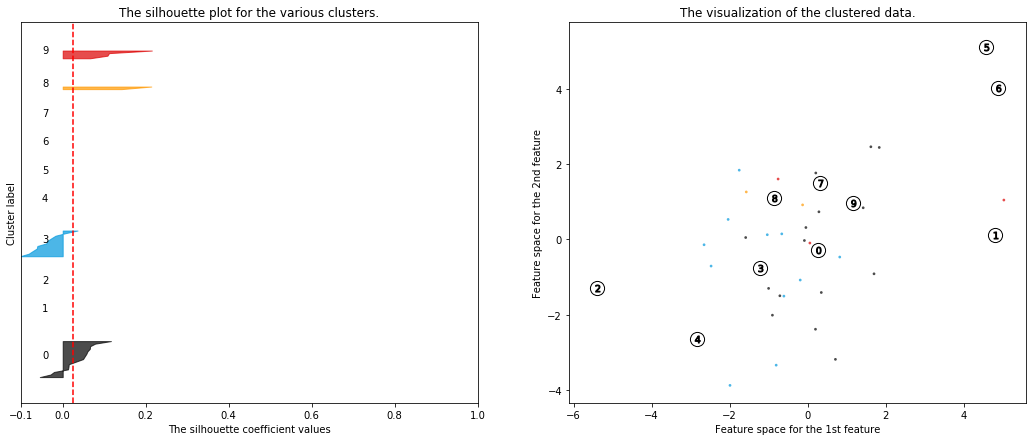

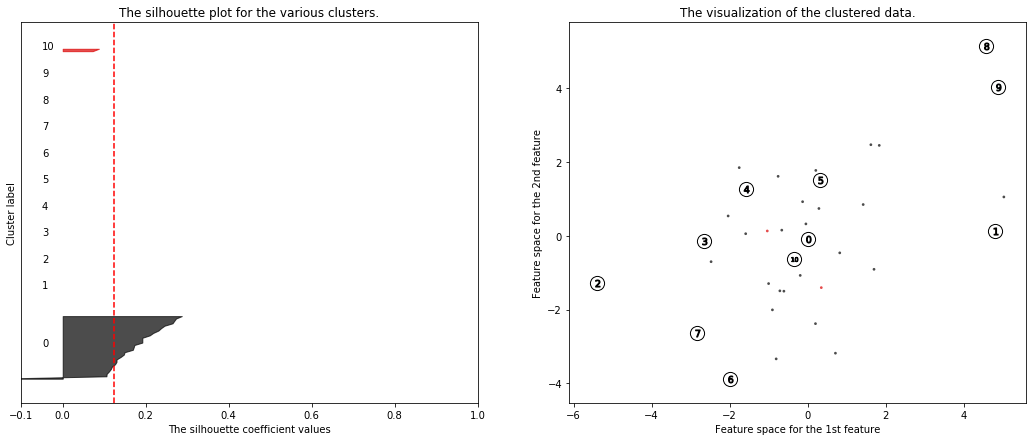

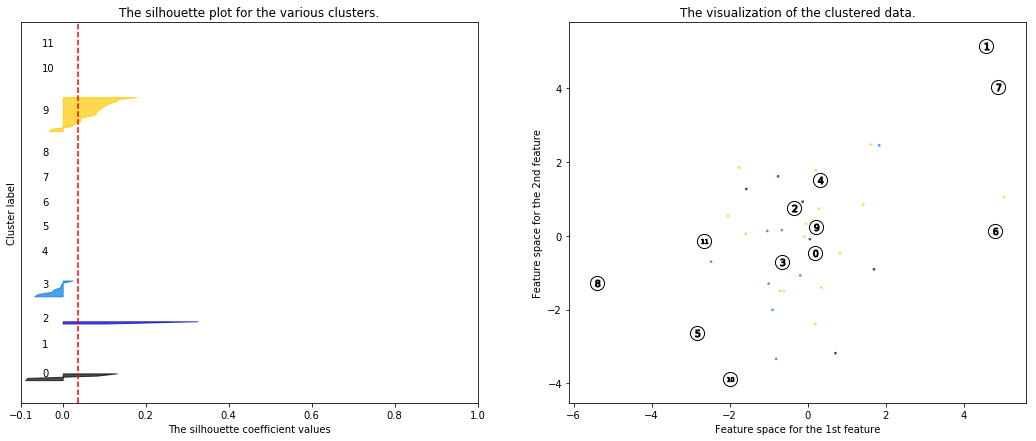

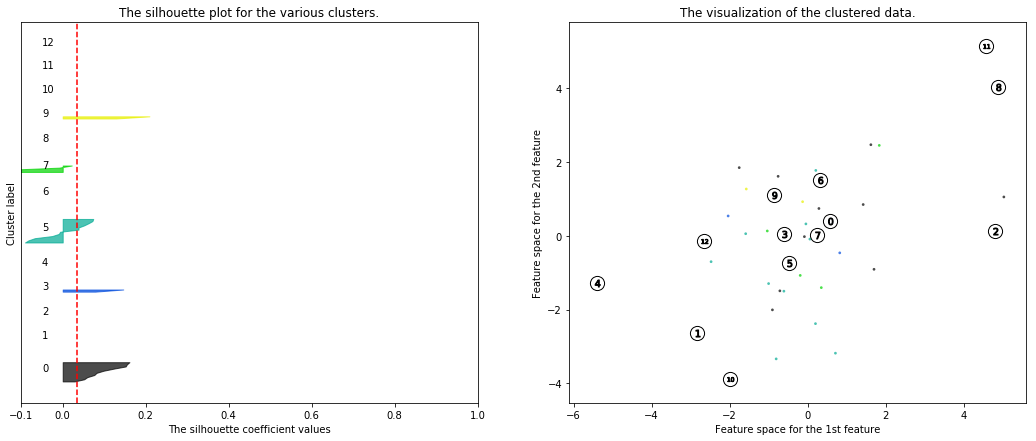

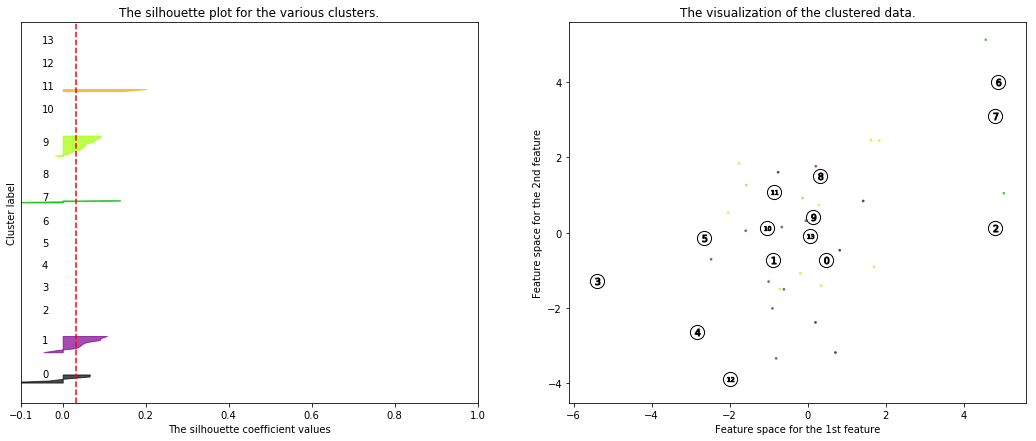

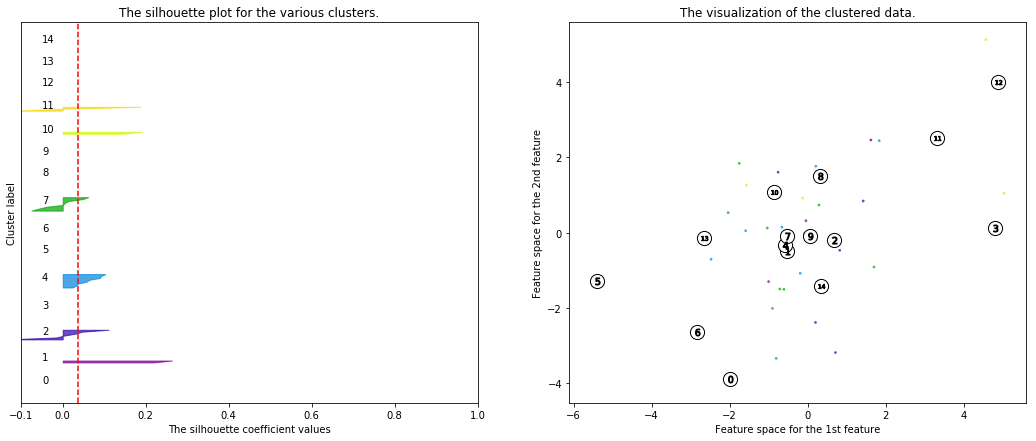

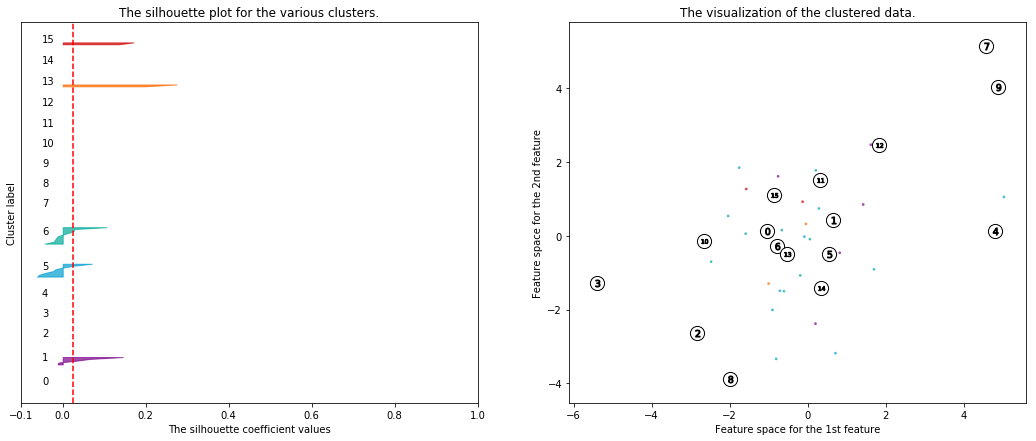

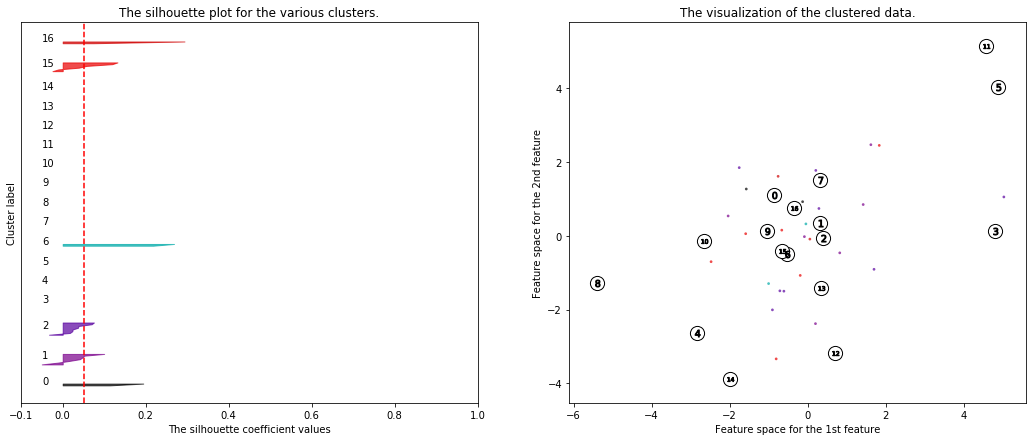

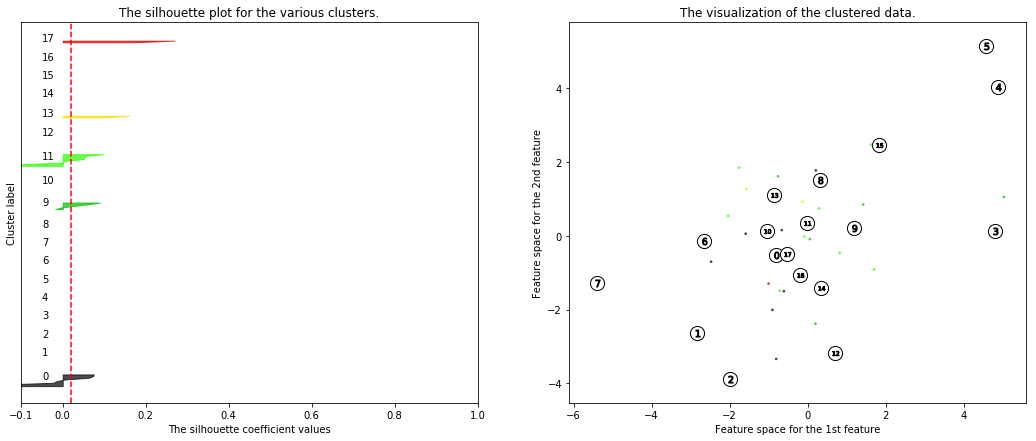

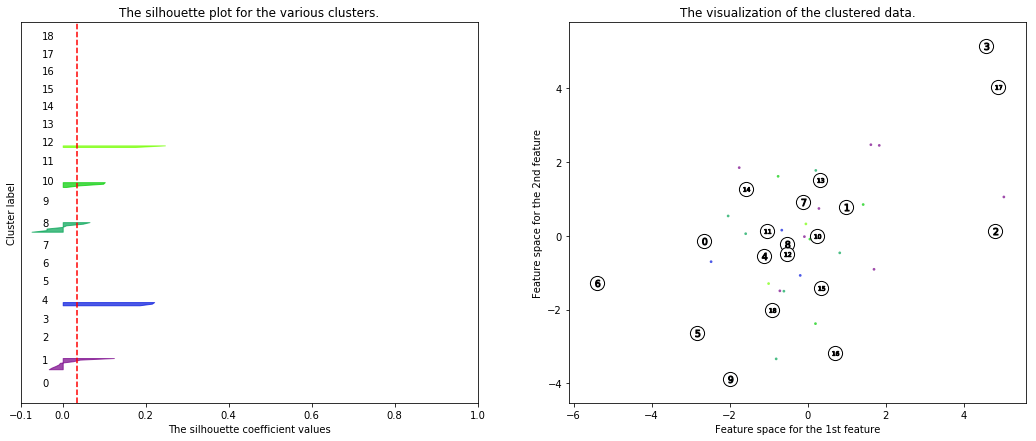

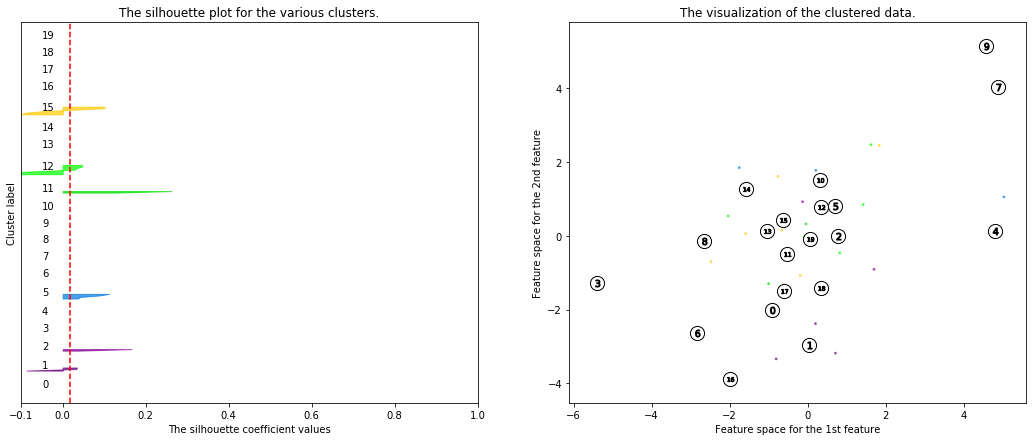

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_embedded) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, algorithm="full")
    cluster_labels = clusterer.fit_predict(X_embedded)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_embedded, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_embedded, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")


plt.show()

#### run *k*-means to cluster the neighborhood into 5 clusters.

In [39]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10, algorithm="full").fit(X_embedded)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 2, 2, 0, 0, 4, 4, 2, 0, 4, 4, 0, 2, 0, 2, 0, 4, 3, 2, 0, 4,
       4, 4, 0, 1, 2, 4, 4, 0, 2, 0, 2, 2, 4, 2, 4, 2], dtype=int32)

In [40]:
neighborhoods_venues_sorted.set_index('Neighborhood').reset_index().rename(columns={'Neighborhood': 'Neighbourhood'}).head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, Richmond, King",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Asian Restaurant,Breakfast Spot,Gym,Hotel,American Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar,Seafood Restaurant,Café,Cheese Shop,Steakhouse,Park
2,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Breakfast Spot,Café,Stadium,Restaurant,Italian Restaurant,Caribbean Restaurant,Intersection,Climbing Gym,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Pizza Place,Garden,Comic Shop,Gym / Fitness Center,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, King and Spadina, Isl...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Sculpture Garden,Boat or Ferry


In [41]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass

neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

toronto_merged = df_tor

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4,Coffee Shop,Bakery,Park,Pub,Café,Restaurant,Theater,Breakfast Spot,Mexican Restaurant,Health Food Store
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Fast Food Restaurant,Tea Room,Ramen Restaurant,Bubble Tea Shop,Plaza
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Coffee Shop,Hotel,Italian Restaurant,Restaurant,Café,Cocktail Bar,Beer Bar,Breakfast Spot,Clothing Store,Gastropub
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Coffee Shop,Pub,Health Food Store,Trail,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Women's Store
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar,Seafood Restaurant,Café,Cheese Shop,Steakhouse,Park


#### Visualize resulting clustering

In [42]:
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Clustering 1

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Downtown Toronto,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Fast Food Restaurant,Tea Room,Ramen Restaurant,Bubble Tea Shop,Plaza
20,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar,Seafood Restaurant,Café,Cheese Shop,Steakhouse,Park
30,Downtown Toronto,0,Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Asian Restaurant,Breakfast Spot,Gym,Hotel,American Restaurant
31,West Toronto,0,Bakery,Pharmacy,Supermarket,Pizza Place,Middle Eastern Restaurant,Music Venue,Park,Coffee Shop,Café,Brewery
47,East Toronto,0,Pizza Place,Gym,Ice Cream Shop,Pet Store,Movie Theater,Pub,Sandwich Place,Burrito Place,Burger Joint,Brewery
48,Downtown Toronto,0,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Seafood Restaurant,Deli / Bodega,Bakery,Steakhouse,Gastropub
54,East Toronto,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Comfort Food Restaurant,Convenience Store,Brewery,Seafood Restaurant,Sandwich Place
73,Central Toronto,0,Sporting Goods Shop,Coffee Shop,Clothing Store,Park,Dessert Shop,Burger Joint,Spa,Metro Station,Mexican Restaurant,Salon / Barbershop
86,Central Toronto,0,Coffee Shop,Pub,Pizza Place,American Restaurant,Restaurant,Liquor Store,Sports Bar,Bagel Shop,Supermarket,Sushi Restaurant
87,Downtown Toronto,0,Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Sculpture Garden,Boat or Ferry


#### Clustering 2

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,1,Garden,Women's Store,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


#### Clustering 3

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,East Toronto,2,Coffee Shop,Pub,Health Food Store,Trail,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Women's Store
36,Downtown Toronto,2,Coffee Shop,Hotel,Aquarium,Italian Restaurant,Café,Fried Chicken Joint,Pizza Place,Bakery,Scenic Lookout,Brewery
37,West Toronto,2,Bar,Coffee Shop,Asian Restaurant,French Restaurant,Restaurant,Wine Bar,Café,Cocktail Bar,Pizza Place,Boutique
43,West Toronto,2,Coffee Shop,Breakfast Spot,Café,Stadium,Restaurant,Italian Restaurant,Caribbean Restaurant,Intersection,Climbing Gym,Bakery
68,Central Toronto,2,Sushi Restaurant,Park,Jewelry Store,Trail,Women's Store,Eastern European Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Ethiopian Restaurant
69,West Toronto,2,Mexican Restaurant,Café,Italian Restaurant,Gastropub,Bar,Fried Chicken Joint,Bakery,Speakeasy,Furniture / Home Store,Discount Store
74,Central Toronto,2,Coffee Shop,Café,Sandwich Place,Pizza Place,Pharmacy,Indian Restaurant,Gym,Pub,Burger Joint,Cosmetics Shop
80,Downtown Toronto,2,Café,Bar,Japanese Restaurant,Bookstore,Restaurant,Bakery,Poutine Place,Beer Bar,Beer Store,Sandwich Place
81,West Toronto,2,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Diner,Italian Restaurant,Bookstore,Indie Movie Theater,Bar,Food
83,Central Toronto,2,Playground,Gym,Restaurant,Park,Women's Store,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


#### Clustering 4

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,3,Park,Bus Line,Dim Sum Restaurant,Swim School,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


#### Clustering 5

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,4,Coffee Shop,Bakery,Park,Pub,Café,Restaurant,Theater,Breakfast Spot,Mexican Restaurant,Health Food Store
15,Downtown Toronto,4,Coffee Shop,Hotel,Italian Restaurant,Restaurant,Café,Cocktail Bar,Beer Bar,Breakfast Spot,Clothing Store,Gastropub
24,Downtown Toronto,4,Coffee Shop,Italian Restaurant,Ice Cream Shop,Café,Burger Joint,Sandwich Place,Middle Eastern Restaurant,Bakery,Chinese Restaurant,Restaurant
25,Downtown Toronto,4,Café,Grocery Store,Park,Convenience Store,Coffee Shop,Baby Store,Diner,Restaurant,Nightclub,Italian Restaurant
41,East Toronto,4,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Dessert Shop,Bubble Tea Shop,Sports Bar,Spa,Juice Bar
42,Downtown Toronto,4,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Italian Restaurant,Bakery,Gym,Bar,Gastropub
67,Central Toronto,4,Sandwich Place,Breakfast Spot,Gym,Park,Hotel,Dog Run,Dance Studio,Clothing Store,Food & Drink Shop,Eastern European Restaurant
75,West Toronto,4,Breakfast Spot,Gift Shop,Bookstore,Dessert Shop,Movie Theater,Dog Run,Restaurant,Italian Restaurant,Bar,Eastern European Restaurant
79,Central Toronto,4,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Thai Restaurant,Café,Italian Restaurant,Restaurant,Coffee Shop,Brewery
84,Downtown Toronto,4,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Mexican Restaurant,Bar,Dumpling Restaurant,Bakery,Coffee Shop,Park


## Conclusion

In my attempts to create a good clusterings of toronto's neighborhood using kmeans, I found the best k as 4. I used various feature engineering such as one hot encoding, dimensional reduction, etc. And found the prefered k using silhouette analysis.

By oberserving the clustering, One can see that the clustering make sense. For example, cluster 1 is geologically on the east and cluster 3 is geologically on the west, most common venue for cluster 3 are coffee shop and cafe, etc.
